1. **Install libraries**

In [2]:
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from google.colab import files
files.upload()   # This will open a file picker to upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmedterass","key":"2c8ff90744762b7d4bb292f1d19d0d1e"}'}

2. **Dataset Preparation**

In [16]:
# ===============================
# 🍌 Banana Ripeness Dataset Prep (Working)
# ===============================

# 1. Installer Kaggle (si Colab)
!pip install -q kaggle

# 2. Authentification Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Télécharger et décompresser
!kaggle datasets download -d shahriar26s/banana-ripeness-classification-dataset -p ./banana_data
!unzip -q -o ./banana_data/banana-ripeness-classification-dataset.zip -d ./banana_data

# 4. Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

data_dir = "./banana_data/Banana Ripeness Classification Dataset"

# 5. Mapping classes -> days
ripeness_to_days = {
    "unripe": 7.0,
    "partiallyripe": 5.0,
    "ripe": 3.0,
    "overripe": 1.0,
    "rotten": 0.0
}

# 6. Créer labels.csv à partir des sous-dossiers train + valid
all_files = glob.glob(os.path.join(data_dir, 'train', '**', '*.jpg'), recursive=True) + \
            glob.glob(os.path.join(data_dir, 'valid', '**', '*.jpg'), recursive=True)

records = []
for f in all_files:
    cls_name = os.path.basename(os.path.dirname(f)).lower()
    if cls_name in ripeness_to_days:
        records.append([os.path.relpath(f, data_dir), ripeness_to_days[cls_name]])

df = pd.DataFrame(records, columns=["filepath", "days_to_rotten"])
df.to_csv("labels.csv", index=False)
print("✅ labels.csv created with", len(df), "entries")

# 7. Dataset PyTorch
class BananaRipenessDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["filepath"])
        image = Image.open(img_path).convert("RGB")
        # <-- Conversion explicite en float32
        label = torch.tensor(row["days_to_rotten"], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

# 8. Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 9. Train/val split
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df["days_to_rotten"], random_state=42)

train_dataset = BananaRipenessDataset(df_train, data_dir, transform=train_transform)
val_dataset   = BananaRipenessDataset(df_val,   data_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)

print("✅ Data ready: Train =", len(train_dataset), " Val =", len(val_dataset))

Dataset URL: https://www.kaggle.com/datasets/shahriar26s/banana-ripeness-classification-dataset
License(s): apache-2.0
banana-ripeness-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ labels.csv created with 12916 entries
✅ Data ready: Train = 10332  Val = 2584


3. **Load Pretrained ResNet and Modify for Regression**

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Regression output
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**4.Define Loss and Optimizer**





In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

**5. Training Loop**

In [19]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 1.1755, Val Loss: 0.3364
Epoch 2/10, Train Loss: 0.4114, Val Loss: 0.2341
Epoch 3/10, Train Loss: 0.3112, Val Loss: 0.2834
Epoch 4/10, Train Loss: 0.2215, Val Loss: 0.2205
Epoch 5/10, Train Loss: 0.2017, Val Loss: 0.2106
Epoch 6/10, Train Loss: 0.1751, Val Loss: 0.1839
Epoch 7/10, Train Loss: 0.1592, Val Loss: 0.2243
Epoch 8/10, Train Loss: 0.1652, Val Loss: 0.1868
Epoch 9/10, Train Loss: 0.1432, Val Loss: 0.2174
Epoch 10/10, Train Loss: 0.1244, Val Loss: 0.2029


**6.Inference Example**

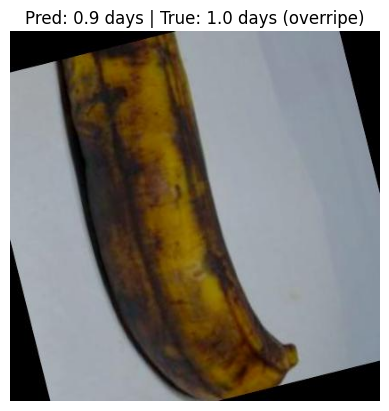

('./banana_data/Banana Ripeness Classification Dataset/train/overripe/musa-acuminata-overripe-801ddf5b-2653-11ec-99f0-d8c4975e38aa_jpg.rf.20e3a8c8f3dae257533405074891efec.jpg',
 0.9150238633155823,
 1.0)

In [24]:
import random
import matplotlib.pyplot as plt

def predict_random_image(model, root_dir="./banana_data/Banana Ripeness Classification Dataset"):
    # 1. Pick a random split (train / test / valid)
    split = random.choice(["train", "test", "valid"])

    # 2. Pick a random class (Unripe / Ripe / Overripe / etc.)
    class_dir = os.path.join(root_dir, split)
    class_name = random.choice(os.listdir(class_dir))

    # 3. Pick a random image from that class
    img_dir = os.path.join(class_dir, class_name)
    img_name = random.choice(os.listdir(img_dir))
    img_path = os.path.join(img_dir, img_name)

    # 4. Open the image and apply the same preprocessing as validation
    image = Image.open(img_path).convert("RGB")
    input_tensor = val_transform(image).unsqueeze(0).to(device)

    # 5. Get prediction from model
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_days = output.item()

    # 6. Get ground-truth days from ripeness_to_days mapping
    true_days = ripeness_to_days.get(class_name, None)

    # 7. Show the image with prediction vs ground truth
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {pred_days:.1f} days | True: {true_days:.1f} days ({class_name})")
    plt.show()

    return img_path, pred_days, true_days

# Example usage:
predict_random_image(model)


7. Improvements

7.1. Freeze Early Layers (Fine-Tuning)

Instead of retraining the whole ResNet from scratch, we freeze the earlier layers (which capture generic features like edges, textures) and only fine-tune later layers.

In [25]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # freeze all layers

# Unfreeze only the last block + FC
for param in model.layer4.parameters():
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

7.2. Data augmentation

In [26]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [27]:
train_dataset = BananaRipenessDataset(df_train, data_dir, transform=train_transform)
val_dataset   = BananaRipenessDataset(df_val,   data_dir, transform=val_transform)

7.3. Learning rate scheduler

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# 1. Model (ResNet18)
# ----------------------
from torchvision import models

model = models.resnet18(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False
# Unfreeze last block + fc
for param in model.layer4.parameters():
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # regression output
model = model.to(device)

# ----------------------
# 2. Loss & Optimizer
# ----------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ----------------------
# 3. Training Loop
# ----------------------
num_epochs = 20

def evaluate(loader):
    model.eval()
    total_loss, total_mae = 0.0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            mae = torch.mean(torch.abs(outputs - labels))
            total_loss += loss.item() * images.size(0)
            total_mae  += mae.item()  * images.size(0)
    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(train_loss=running_loss / ((loop.n+1)*images.size(0)))

    # Scheduler step
    scheduler.step()

    # Evaluation
    train_loss, train_mae = evaluate(train_loader)
    val_loss, val_mae = evaluate(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.2f} "
          f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.2f}")


Epoch 1/20: 100%|██████████| 323/323 [00:58<00:00,  5.49it/s, train_loss=1.68]


Epoch [1/20] Train Loss: 0.3812, Train MAE: 0.43 Val Loss: 0.4273, Val MAE: 0.44


Epoch 2/20: 100%|██████████| 323/323 [00:59<00:00,  5.43it/s, train_loss=0.562]


Epoch [2/20] Train Loss: 0.2615, Train MAE: 0.35 Val Loss: 0.3065, Val MAE: 0.35


Epoch 3/20: 100%|██████████| 323/323 [00:58<00:00,  5.49it/s, train_loss=0.446]


Epoch [3/20] Train Loss: 0.2028, Train MAE: 0.30 Val Loss: 0.2734, Val MAE: 0.32


Epoch 4/20: 100%|██████████| 323/323 [00:58<00:00,  5.55it/s, train_loss=0.36]


Epoch [4/20] Train Loss: 0.2150, Train MAE: 0.32 Val Loss: 0.2861, Val MAE: 0.33


Epoch 5/20: 100%|██████████| 323/323 [00:59<00:00,  5.45it/s, train_loss=0.305]


Epoch [5/20] Train Loss: 0.1473, Train MAE: 0.25 Val Loss: 0.2341, Val MAE: 0.29


Epoch 6/20: 100%|██████████| 323/323 [00:58<00:00,  5.47it/s, train_loss=0.249]


Epoch [6/20] Train Loss: 0.1087, Train MAE: 0.19 Val Loss: 0.1824, Val MAE: 0.23


Epoch 7/20: 100%|██████████| 323/323 [00:59<00:00,  5.40it/s, train_loss=0.223]


Epoch [7/20] Train Loss: 0.0982, Train MAE: 0.19 Val Loss: 0.1992, Val MAE: 0.24


Epoch 8/20: 100%|██████████| 323/323 [00:58<00:00,  5.52it/s, train_loss=0.183]


Epoch [8/20] Train Loss: 0.0993, Train MAE: 0.20 Val Loss: 0.2179, Val MAE: 0.25


Epoch 9/20: 100%|██████████| 323/323 [00:58<00:00,  5.51it/s, train_loss=0.171]


Epoch [9/20] Train Loss: 0.0960, Train MAE: 0.19 Val Loss: 0.2110, Val MAE: 0.24


Epoch 10/20: 100%|██████████| 323/323 [00:59<00:00,  5.45it/s, train_loss=0.155]


Epoch [10/20] Train Loss: 0.0828, Train MAE: 0.17 Val Loss: 0.1771, Val MAE: 0.22


Epoch 11/20: 100%|██████████| 323/323 [01:00<00:00,  5.34it/s, train_loss=0.134]


Epoch [11/20] Train Loss: 0.0658, Train MAE: 0.14 Val Loss: 0.1549, Val MAE: 0.18


Epoch 12/20: 100%|██████████| 323/323 [00:59<00:00,  5.39it/s, train_loss=0.128]


Epoch [12/20] Train Loss: 0.0732, Train MAE: 0.16 Val Loss: 0.1575, Val MAE: 0.19


Epoch 13/20: 100%|██████████| 323/323 [00:58<00:00,  5.49it/s, train_loss=0.113]


Epoch [13/20] Train Loss: 0.0585, Train MAE: 0.14 Val Loss: 0.1549, Val MAE: 0.19


Epoch 14/20: 100%|██████████| 323/323 [00:58<00:00,  5.51it/s, train_loss=0.111]


Epoch [14/20] Train Loss: 0.0562, Train MAE: 0.13 Val Loss: 0.1493, Val MAE: 0.18


Epoch 15/20: 100%|██████████| 323/323 [00:59<00:00,  5.46it/s, train_loss=0.103]


Epoch [15/20] Train Loss: 0.0588, Train MAE: 0.14 Val Loss: 0.1439, Val MAE: 0.17


Epoch 16/20: 100%|██████████| 323/323 [00:59<00:00,  5.43it/s, train_loss=0.0935]


Epoch [16/20] Train Loss: 0.0537, Train MAE: 0.12 Val Loss: 0.1464, Val MAE: 0.17


Epoch 17/20: 100%|██████████| 323/323 [00:59<00:00,  5.46it/s, train_loss=0.0869]


Epoch [17/20] Train Loss: 0.0495, Train MAE: 0.12 Val Loss: 0.1457, Val MAE: 0.17


Epoch 18/20: 100%|██████████| 323/323 [00:58<00:00,  5.54it/s, train_loss=0.0848]


Epoch [18/20] Train Loss: 0.0477, Train MAE: 0.12 Val Loss: 0.1521, Val MAE: 0.17


Epoch 19/20: 100%|██████████| 323/323 [00:58<00:00,  5.48it/s, train_loss=0.0824]


Epoch [19/20] Train Loss: 0.0456, Train MAE: 0.11 Val Loss: 0.1501, Val MAE: 0.16


Epoch 20/20: 100%|██████████| 323/323 [00:59<00:00,  5.43it/s, train_loss=0.0842]


Epoch [20/20] Train Loss: 0.0497, Train MAE: 0.11 Val Loss: 0.1409, Val MAE: 0.16


In [32]:
# 'model' est ton modèle entraîné
torch.save(model.state_dict(), "model.pth")
print("✅ Modèle sauvegardé dans model.pth")

✅ Modèle sauvegardé dans model.pth


**Gradio App for Banana Shelf-Life Prediction**

In [31]:
!pip install gradio
torch.save(model.state_dict(), "banana_resnet.pth")


model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("banana_resnet.pth", map_location=device))
model = model.to(device)
model.eval()

# Define prediction function
import gradio as gr

def predict_days(image):
    # Preprocess
    image = val_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
    days = output.item()
    return f"Estimated days to banana death: {days:.1f}"

#Lunch Gradio interface
iface = gr.Interface(
    fn=predict_days,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🍌 Banana Shelf-Life Predictor",
    description="Upload a banana image to estimate how many days it has before going bad."
)

iface.launch()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://75b289dc26b720f043.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
